In [7]:
import re
import numpy as np
import time
import requests
from bs4 import BeautifulSoup
from matplotlib import pyplot as plt, rcParams
import pandas as pd
#from pydataset import data as dt
from matplotlib import pyplot as plt

% matplotlib inline

# Introduction

According to a study done by Science Daily(1), the percentage of persons in the U.S. suffering from depression grew from 6.6 to 7.3 percent from the years 2005 to 2015. This trend has been observed through the last few decades. The National Ambulatory Medical Care Survey(2) found that the number of people diagnosed with depression has increased by 450% since 1987. There is speculation debating whether depression is more common or whether depression is simply being diagnosed more often. This leads to the ambiguity associated with diagnosing depression. Many symptoms of depression overlap with emotions experienced on occasion by all people or with symptoms of other disorders. A study by Everyday Health (3) discussed the cautions to be taken when diagnosing depression. So what is causing depression? And how can we distinguish between someone with clinical depression and someone who is simply going through a rough patch? The goal of this project is to identify conditions that are correlated with depression. 

The exact cause of depression is unknown and may very well not exist. A study by the Mayo Clinic (4) defined the probable causes of depression to be biological differences, brain chemistry, hormones, and inherited traits. The specific attributes relating to these are still unknown. John Hopkins (5) also did a study revealing that depression is caused by an imbalance of brain chemicals though other factors also play a role. They found that depression tends to run in families and can develop with or without a trigger. From these results it's clear that there is still much research to be done regarding the causes of depression. 

For the last 50 years, the Center for Disease Control and Prevention has conducted a survey called the National Health and Nutrition Examination Survey (NHANES). NHANES contains responses over 1200 questions regarding demographic, social, dietary, and physical health history. This project analyzed the data set from 2013-2014 in which over 9800 individuals were surveyed. 

According to studies by the Mayo Clinic (4), John Hopkins (5), Intermountain Health Care (6), and the Anxiety and Depression Association of America (7), the main sympoms of depression are: persistent sadness, feelings of hopelessness, guilt, worthlessness, or helplessness, loss of interest or pleasure in activities, decreased energy, difficulty concentrating, insomnia or oversleeping, low appetite or overeating, thoughts of death or suicide, irritability, moving or speaking so slowly that others notice or feeling so restless that you move around a noticable amount, and feeling like a failure. 

The NHANES survey contains responses to the following 9 questions. How often in the last 2 weeks did you experience:

    Little interest or pleasure in doing things?
    Feeling down, depressed, or hopeless?
    Trouble falling or staying asleep, or sleeping too much?
    Feeling tired or having little energy?
    Poor appetite or overeating?
    Feeling bad about yourself - or that you are a failure or have let yourself or your family down?
    Trouble concentrating on things, such as reading the newspaper or watching TV?
    Moving or speaking noticably slowly? Or being so fidgety or restless that you move around more than usual?
    Feeling that you would be better off dead or of hurting yourself in some way?

    
These questions match exactly the top symptoms for depression identified by these four organizations. The responses to these questions relfect how often the surveyed individual experiences these types of emotions. Since there is not a perfect way for determining if an individual is depressed, the combination of these questions provides a reasonable basis for creating a metric to describe mental health of the individual. This data set thus contains information that can reasonably describe mental health as well as data relating to many of the hypothesized causes of depression. 


1 https://www.sciencedaily.com/releases/2017/10/171030134631.htm

2 http://happierhuman.wpengine.netdna-cdn.com/wp-content/uploads/2014/06/P2.-National-Trends-in-the-Outpatient-Treatment-of-Depression.pdf

3 https://www.everydayhealth.com/depression/could-you-have-been-misdiagnosed-with-depression.aspx

4 https://www.mayoclinic.org/diseases-conditions/depression/symptoms-causes/syc-20356007

5 https://www.hopkinsmedicine.org/healthlibrary/conditions/mental_health_disorders/major_depression_85,P00746

6 https://intermountainhealthcare.org/services/wellness-preventive-medicine/live-well/feel-well/dealing-with-depression/?gclid=EAIaIQobChMIuaneirX71wIViIJ-Ch19qAKWEAAYASAAEgL5j_D_BwE

7 https://adaa.org/understanding-anxiety/depression/symptoms

# Data Collection

#### Gathering Data
The data was available on https://kaggle.com in csv form. The original data is from https://wwwn.cdc.gov/nchs/nhanes/Default.aspx. After loading all the csv files, the data was merged into a single data frame sorted by the person surveyed. 

In [67]:
all_data = {}

# get data from data files
data_files = ["demographic","diet","examination", "labs", "questionnaire"]
for filename in data_files:
    data = pd.read_csv(filename + ".csv")
    all_data[filename] = data

# combine all data into single data frame
data = pd.merge(all_data[data_files[0]],all_data[data_files[1]],on="SEQN")
for j in range(2,len(data_files)):
    data = pd.merge(data,all_data[data_files[j]])

#### Organizing Data
The variable names in the data were extremely ambiguous. The NHANES website contained descriptions for each variable name. The NHANES website was scraped to create a dictionary matching the variable names to their descriptions. After sorting through the descriptions, variables corresponding to data that was hypothesized to be a cause of depression were identified and stored in a list to keep in the resulting dataframe. 

In [68]:
def get_variable_info():
    """
    Crawl through the NHANES site to get variable 
    names and descriptions for data.
    """
    
    variable_info = {}
    to_keep = []
    
    # these are the variables that we are interested in analysing
    to_keep_list = ['URXUMA','DED125','ALQ120Q','ALQ120U',
                    'URXUMS','URXCRS','URDACT','LBXTC','LBXWBCSI',
                    'LBXRBCSI','LBXHGB','LBXPLTSI','LBXSCA',
                    'LBXSGL','LBXSIR','RIAGENDR','RIDAGEYR',
                    'DMDCITZN','DMDEDUC2','DMDMARTL',
                    'INDFMIN2','INDFMPIR','DMDFMSIZ',
                    'RIDRETH3','DMDHHSZA','DMDHHSZB',
                    'DMDHHSZE','DUQ240','MCQ220','BMXWAIST','BMXBMI',
                    'BMXHT','BMXWT','BPXPLS','BPXSY3','BPXSY2',
                    'BPXDI3','BPXDI2','DBD100','DRQSDIET',
                    'SXD021','SLD010H','OCQ180',
                    'SMQ020','WHD020','WHD050','WHD030','WHD070',
                    'DAQ665','PAD680','PAQ710','PAQ715']
    to_keep_re = re.compile('^DPQ0[0-9]{2}$')
    
    datatype_finder = re.compile(r"^(Demographics|Dietary|Examination|Laboratory|Questionnaire)$")
    varpage_finder = re.compile(r"^NHANES 2013-2014.*Variable List$")
    the_base = "https://wwwn.cdc.gov"
    base_url = "https://wwwn.cdc.gov/nchs/nhanes/continuousnhanes/default.aspx?BeginYear=2013"      
    base_soup = BeautifulSoup(requests.get(base_url).text, "html.parser")
    page_tags = base_soup.find_all(name='a', href=True, string=datatype_finder)
    pages = [the_base + tag.attrs["href"] for tag in page_tags]
    
    for page in pages:
        variable_names = []
        variable_descriptions = []
        end = page.find('&')
        key = page[64:end]
        time.sleep(1)           
        soup = BeautifulSoup(requests.get(page).text, "html.parser")
        new_base = the_base + "/nchs/nhanes/search/"
        next_page = new_base + soup.find_all(name="a", string=varpage_finder, href=True)[0].attrs["href"]
        
        time.sleep(1)
        new_soup = BeautifulSoup(requests.get(next_page).text, "html.parser")
        names = new_soup.find_all(name="tr")[2:]

        for name in names:
            temp = name.find_all(name="td")
            varname = temp[0].text
            desc = temp[1].text
            
            if varname in to_keep_list or re.search(to_keep_re, varname):
                to_keep.append(varname)
                variable_info[varname] = desc
            
    return variable_info, to_keep

var_info, to_keep = get_variable_info()

#### Feature Engineering
The following functions describe the feature engineering done to the data set. 

    drop_unwanted():    Drop unwanted columns from the table (columns seemingly completely unrelated to depression).
    unscew_data():      Change 'empty' to NaN (unanswered questions are recorded as 7,9,77,99,777,999,7777,9999,etc). 
    average_bp():       Replace multiple blood pressure data columns with single average.
    adjust_alcohol():   Adjust alcohol consumption to account for different units in responses.
    weight_change():    Replace data with previous year's weight with data representing weight gained in last year.
    screen_time():      Create column with combination of time spent on computer and time spent on TV.
    drop_nans():        Eliminate rows of table that have NaN for at least 20 of the columns.
    score_depression(): Combine the results from the 9 mental health questions to create mental health score. 
    replace_names():    Replace column names with more meaningful names based on scraped variable descriptions. 
    
The resulting dataframe now 6468 rows and 52 columns (52 results for 6468 people surveyed).

In [69]:
def drop_unwanted(data, to_keep):
    """
    generate drop list from list of variables to keep and drop unwanted
    """
    drop_list = [c for c in data.columns if c not in to_keep]
    data.drop(drop_list,axis=1, inplace=True)
    return data

def unscew_data(data):
    """
    set general unanswered questions to NaN as to no scew data
    the numbers 77,777,7777,77777,99,999,9999,99999 represent unanswered questions
    setting these numbers to NaN will prevent inaccurate outliers from appearing in the data
    
    in the mental health data, the numbers 7 and 9 represent unanswered questions
    set these numbers to NaN in the mental health data to prevent data from being scewed
    """
    data[(data == 777.0) | (data == 999.0) | (data == 77.0) | (data == 99.0) | (data == 7.0) | (data == 9.0) |(data == 7777.0) | (data == 9999.0) | (data == 77777.0) | (data == 99999.0)] = np.nan
    return data

def average_bp(data, var_info):
    """
    average blood pressure data and replace with averages
    """
    data['BPXSY'] = data[['BPXSY3','BPXSY2']].mean(axis=1)
    data['BPXDI'] = data[['BPXDI3','BPXDI2']].mean(axis=1)
    data.drop(['BPXSY3','BPXSY2','BPXDI3','BPXDI2'], axis=1, inplace=True)
    var_info['BPXSY'] = 'Systolic:  Blood pressure mm Hg'
    var_info['BPXDI'] = 'Diastolic: Blood pressure mm Hg'
    return data, var_info

def adjust_alcohol(data, var_info):
    # adjust alcohol consumption data for different units
    units = {1:(1/7),2:(12/365),3:(1/365)}
    data = data.replace({'ALQ120U':units})
    data['ALQ120'] = data['ALQ120Q'].multiply(data['ALQ120U'], axis='index')
    data.drop(['ALQ120Q','ALQ120U'], axis=1, inplace=True)
    var_info['ALQ120'] = 'Number of times alcohol is consumed per day'
    return data, var_info

def weight_change(data, var_info):
    # create column corresponding to weight gained in last year
    # remove column corresponding to previous year's weight
    data['WHD0250'] = data[['WHD020']].sub(data['WHD050'], axis='index')
    var_info['WHD0250'] = 'Weight gained in the last year'
    data.drop(['WHD050','WHD020'], axis=1, inplace=True)
    return data, var_info

def screen_time(data, var_info):
    # combine column with amount of time spent on computer with column with time spent on TV
    # this will create one column that represents the amount of 'screen' time
    data['PAQ700'] = data['PAQ710'] + data['PAQ715']
    var_info['PAQ700'] = 'Hours spent of TV or computer on average per week'
    data.drop(['PAQ710','PAQ715'], axis=1, inplace=True)
    return data, var_info
    
def drop_nans(data):
    # drop rows that have NaN for at least 20 columns
    null_count = data.isnull().sum(axis=1)
    data = data[null_count <= 20]
    return data

def score_depression(data, var_info):
    mental_health = ['DPQ010','DPQ020','DPQ030','DPQ040','DPQ050', 'DPQ060','DPQ070','DPQ080','DPQ090']
    temp = data[mental_health]
    total = temp.sum(axis=1)

    count_0 = (temp == 0.0).astype(int).sum(axis=1)
    count_1 = (temp == 1.0).astype(int).sum(axis=1)
    count_2 = (temp == 2.0).astype(int).sum(axis=1)
    count_3 = (temp == 3.0).astype(int).sum(axis=1)
    
    data['DPQ000'] = total
    var_info['DPQ000'] = 'Computed depression score. Scores range 0 to 27, 27 being most depressed.'
    return data, var_info

def replace_names(data, var_info, converter):
    column_names = converter.split('\n')

    dictionary_column_names = {}
    variable_descriptions = {}

    for line in column_names:
        one, two = re.match(re.compile(r'(\S+)\s(.*)$'), line).groups()
        dictionary_column_names[one] = two
        variable_descriptions[two] = var_info[one]

    for key in dictionary_column_names.keys():
        if key in data.columns:
            data[dictionary_column_names[key]] = data[key]
            data.drop(key, axis=1, inplace=True)
            
    return data, variable_descriptions

In [70]:
data = drop_unwanted(data, to_keep)
data = unscew_data(data)
data, var_info = average_bp(data, var_info)
data, var_info = adjust_alcohol(data, var_info)
data, var_info = weight_change(data, var_info)
data, var_info = screen_time(data, var_info)
data = drop_nans(data)
data , var_info = score_depression(data, var_info)
    
converter = 'ALQ120 Alcohol\nPAQ700 Computer/TV\nBMXBMI BMI\nBMXHT Height\nBMXWAIST Waist\nBMXWT Weight\nBPXDI BP1\nBPXPLS Pulse\nBPXSY BP2\nDBD100 Salt\nDED125 Time Outside\nDMDCITZN US Citizen\nDMDEDUC2 Education\nDMDFMSIZ Family Size\nDMDHHSZA Children <= 5 \nDMDHHSZB Children 6-17\nDMDHHSZE Adults > 60 at Home\nDMDMARTL Marital Status\nDPQ000 Depression\nDPQ010 Little Interest\nDPQ020 Feeling Hopeless\nDPQ030 Trouble Sleeping\nDPQ040 Low Energy\nDPQ050 Irregular Appetite\nDPQ060 Feel Like Failure\nDPQ070 Trouble Concentrating\nDPQ080 Slow or Fidgity \nDPQ090 Self Harm\nDRQSDIET Diet\nDUQ240 Drugs\nINDFMIN2 Income\nINDFMPIR Poverty Ratio\nLBXHGB Hemoglobin\nLBXPLTSI Platelets\nLBXRBCSI Red blood cell\nLBXSCA Calcium\nLBXSGL Glucose\nLBXSIR Iron\nLBXTC Cholesterol\nLBXWBCSI White blood cell\nMCQ220 Cancer\nOCQ180 Hours Worked\nPAD680 Time Sitting\nPAQ710 TV Use\nPAQ715 Computer Use\nRIAGENDR Gender\nRIDAGEYR Age\nRIDRETH3 Race\nSLD010H Sleep \nSMQ020 Smoking\nSXD021 Sex\nURDACT ACR\nURXCRS Creatinine\nURXUMA Albumin\nURXUMS Albumin\nWHD0250 Weight Change'
data, variable_descriptions = replace_names(data, var_info, converter)
    
data

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:2464: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._where(-key, value, inplace=True)


,Alcohol,Computer/TV,BMI,Height,Waist,Weight,BP1,Pulse,BP2,Salt,...,Gender,Age,Race,Sleep,Smoking,Sex,ACR,Creatinine,Albumin,Weight Change
0,0.002740,10.0,26.7,171.3,100.0,78.3,75.0,86.0,108.0,2.0,...,1,69.0,4.0,NaN,1.0,1.0,11.03,3447.6,4.3,-30.0
1,NaN,12.0,28.6,176.8,107.6,89.5,61.0,74.0,158.0,2.0,...,1,54.0,3.0,NaN,1.0,1.0,306.00,4420.0,153.0,40.0
2,NaN,4.0,28.9,175.3,109.2,88.9,78.0,68.0,143.0,1.0,...,1,72.0,3.0,8.0,1.0,NaN,10.53,9989.2,11.9,0.0
4,NaN,2.0,19.7,162.4,NaN,52.0,87.0,92.0,138.0,NaN,...,2,73.0,3.0,NaN,2.0,NaN,173.47,12994.8,255.0,-30.0
5,0.013699,13.0,41.7,158.7,123.1,105.0,81.0,60.0,156.0,3.0,...,1,56.0,1.0,5.0,1.0,1.0,166.22,6541.6,123.0,-5.0
7,0.005479,0.0,35.7,161.8,110.8,93.4,81.0,82.0,125.0,NaN,...,2,61.0,3.0,NaN,2.0,1.0,7.85,21392.8,19.0,0.0
8,0.142857,9.0,26.5,152.8,85.5,61.8,72.0,86.0,119.0,NaN,...,2,56.0,3.0,6.0,1.0,1.0,7.22,1591.2,1.3,0.0
9,0.571429,3.0,22.0,172.4,93.7,65.3,77.0,70.0,142.0,1.0,...,1,65.0,3.0,NaN,1.0,1.0,16.28,19006.0,35.0,0.0
10,0.285714,8.0,20.3,152.5,73.7,47.1,64.0,70.0,104.0,2.0,...,2,26.0,3.0,8.0,2.0,2.0,80.65,2740.4,25.0,-5.0
12,0.005479,4.0,34.4,172.5,122.1,102.4,68.0,72.0,128.0,1.0,...,1,76.0,3.0,6.0,2.0,NaN,14.58,15646.8,25.8,2.0


NOTICE!

For users of this data set:

For details on the units or descriptions of any given column, say column 'X', typing variable_descriptions['X'] will result in the description of the column 'X'. 

# Data Visualization
Recall: This data contains responses to the following questions. 

Over the last 2 weeks, how often have you been bothered by the following problems:

    Little Interest:       little interest or pleasure in doing things?
    Feeling Hopeless:      feeling down, depressed, or hopeless?
    Trouble Sleeping:      trouble falling or staying asleep, or sleeping too much?
    Low Energy:            feeling tired or having little energy?
    Irregular Appetite:    poor appetite or overeating?
    Feel Like Failure:     feeling bad about yourself, like you are a failure or have let yourself or family down?
    Trouble Concentrating: trouble concentrating on things, such as reading the newspaper or watching TV?
    Slow or Figety:        noticably moving or speaking so slowly or being so figety or restless?
    Self Harm:             that you would be better off dead or of hurting yourself in some way?
    
The possible responses are:

    0: never
    1: rarely
    2: over half the time
    3: everyday

I compared the responses to these questions against all other information in the data frame and will display the more significant results below.

In [39]:
cool = ['INDFMPIR','PAQ700','BMXBMI','DMDEDUC2','DMDFMSIZ','DMDHHSZA','DMDHHSZB','URDACT']
titles = ['Poverty Ratio', 'Screen Time','BMI', 'Education Level', 'Family Size', 'Number of Children < 5', 'Number of Children 6 - 17', 'Urine']
colors = ['b','m','r','c','y','g','b','m','r','c','y','g']

for i in range(8):
    print(i+1,':',titles[i])
    loc = 0
    for q in mental_health:
        plt.subplot(3,3, loc+1)
        sep = data.groupby(q)
        sep[cool[i]].mean().plot(kind="barh",color=colors[i])
        plt.tight_layout()
        loc += 1

    plt.show()

1 : Poverty Ratio


NameError: name 'mental_health' is not defined

#### Data Analysis

The plots above show the most significant relationships between the mental health results and other data points. 

The first plots shows the ratio of the family's income to their poverty level. Where the higher the ratio, the less the family is in poverty. 
The graphs show that there is definitely positive correlation between higher income levels and better mental health. 

The second plots shows the amount of hours spent on TV or computer each week. 
Though less significant than the poverty ratio, these plots show that there is a positive correlation between time spent on the TV and computer and poor mental health. 

The third and fourth plots show less significant relationships.
The third shows the BMI of each individual and the fourth shows the education level (2 being below high school, 3 high school, and 4 college). 
The very minimal correlation between these characteristics and mental health is also true for the graphs showing waist circumference, weight, height, race, and age (not pictures here).


The fifth, sixth, and seventh plots show data regarding the number of individuals in the household. The fifth shows there is not a relationship between household size and mental health.
But the sixth and seventh plots point to a potential (though minor) correlation between the ages of kids at home and mental health. 

The eigth plots are by far the most interesting. They show a very strong correlation between Albumin creatinine ratio in the urine and responses to mental health questions. 

INDFMPIR


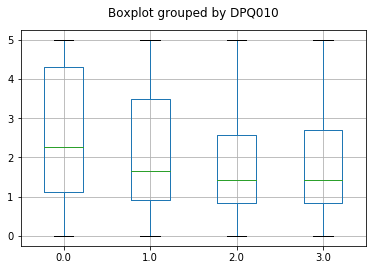

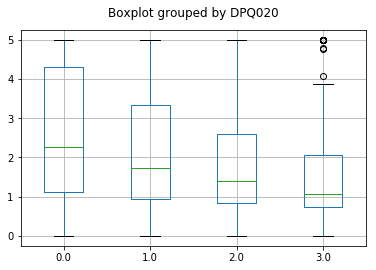

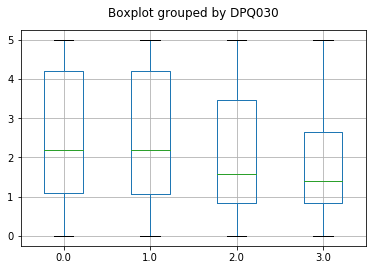

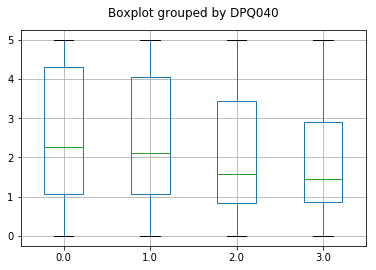

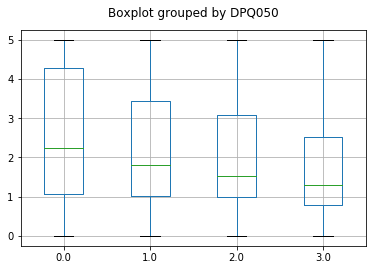

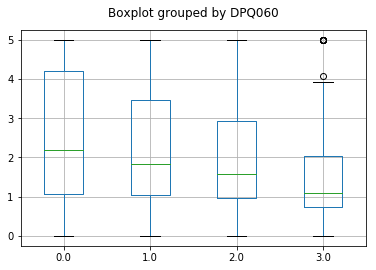

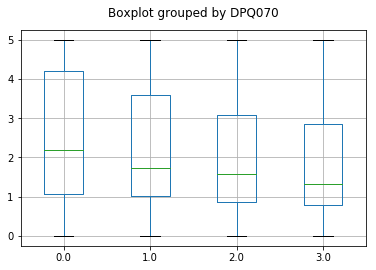

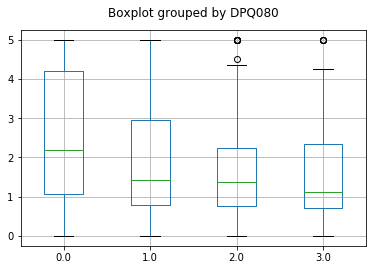

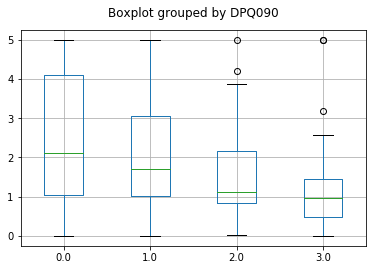

PAQ700


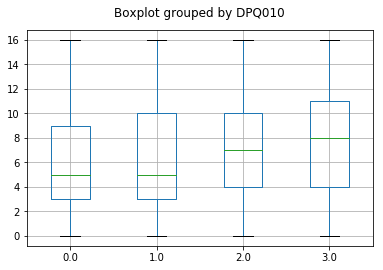

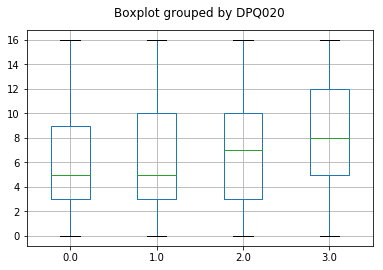

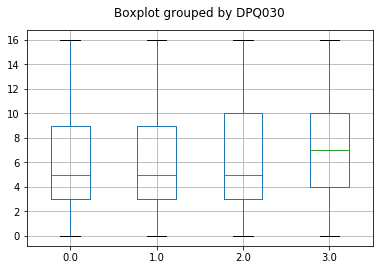

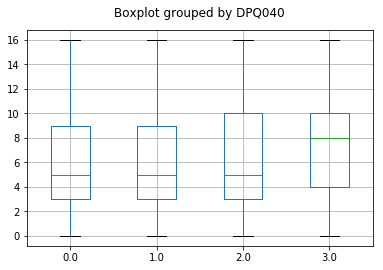

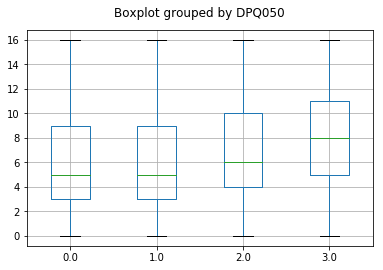

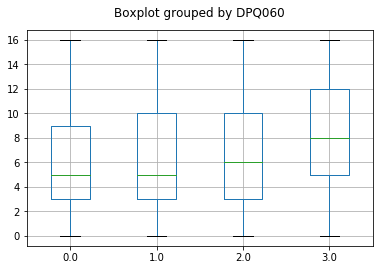

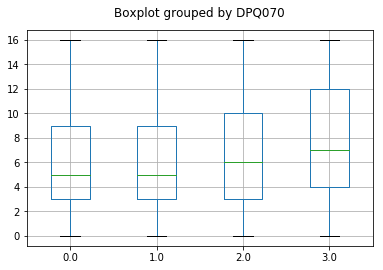

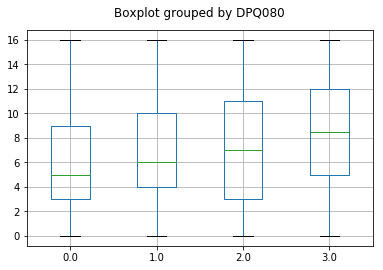

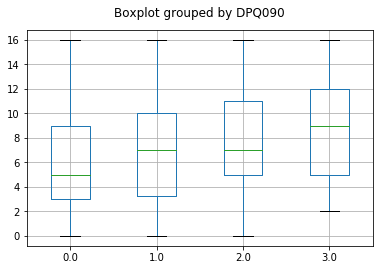

In [8]:
sig = ['INDFMPIR','PAQ700']

for i in sig:
    print(i)
    for q in mental_health:
        sep = data.groupby(q)

        data.boxplot(i, by=q)
        plt.title('')
        plt.xlabel('')
        plt.show()

### Data Analysis

The above plots give a closer look into the relationships between poverty ratio and mental health and screen time and mental health. The plots enforce the orginial observations that some sort of relationship exists though not an extremely strong one. 

# Conclusion
For the most part the factors relating to mental health problems are not surprising. 

'ALQ120 Alcohol Consumption\nBMXBMI BMI (kg/m**2)\nBMXHT Height (cm)\nBMXWAIST Waist Circumference (cm)\nBMXWT Weight (kg)\nBPXDI Diastolic Blood pressure (mmHg)\nBPXPLS 60 sec pulse\nBPXSY Systolic Blood pressure (mmHg)\nDBD100 Salt added to food\nDED125 Time spent outdoors\nDMDCITZN US Citizen\nDMDEDUC2 Education Level\nDMDFMSIZ Family Size\nDMDHHSZA Children <= 5 \nDMDHHSZB Children aged 6-17\nDMDHHSZE Adults > 60 at Home\nDMDMARTL Marital Status\nDPQ010 Little Interest\nDPQ020 Feeling Hopeless\nDPQ030 Trouble Sleeping\nDPQ040 Low Energy\nDPQ050 Irregular Appetite\nDPQ060 Feel Like Failure\nDPQ070 Trouble Concentrating\nDPQ080 Restless\nDPQ090 Self Harm\nDRQSDIET Diet\nDUQ240 Drugs\nINDFMIN2 Total family income\nINDFMPIR Poverty Ratio\nLBXHGB Hemoglobin (g/dL)\nLBXPLTSI Platelet count (1000 cells/uL)\nLBXRBCSI Red blood cell (million cells/uL)\nLBXSCA Total calcium (mg/dL)\nLBXSCH Cholesterol (mg/dL)\nLBXSGL Glucose, refrigerated serum (mg/dL)\nLBXSIR Iron, refrigerated serum (ug/dL

In [81]:
temp

,DPQ010,DPQ020,DPQ030,DPQ040,DPQ050,DPQ060,DPQ070,DPQ080,DPQ090
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.0,1.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0
5,3.0,3.0,3.0,3.0,3.0,1.0,2.0,1.0,0.0
7,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,0.0,1.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0


In [82]:
total = temp.sum(axis=1)

count_0 = (temp == 0.0).astype(int).sum(axis=1)
count_1 = (temp == 1.0).astype(int).sum(axis=1)
count_2 = (temp == 2.0).astype(int).sum(axis=1)
count_3 = (temp == 3.0).astype(int).sum(axis=1)

In [72]:
temp

,DPQ010,DPQ020,DPQ030,DPQ040,DPQ050,DPQ060,DPQ070,DPQ080,DPQ090,total,0count,1count,2count,3count
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8,2,1,0
1,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,8,0,2,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10,0,0,0
4,2.0,1.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,9.0,5,1,1,2
5,3.0,3.0,3.0,3.0,3.0,1.0,2.0,1.0,0.0,19.0,1,3,1,6
7,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,7,2,2,0
8,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8,2,1,0
9,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,6,3,0,2
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10,0,0,0
12,0.0,1.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,6.0,5,3,0,2


In [108]:
Mental_Health_Score =  np.exp(total+1)

In [84]:
Mental_Health_Score

0        1.5
1        3.0
2        0.0
4       13.5
5       28.5
7        3.0
8        1.5
9        4.5
10       0.0
12       9.0
15       3.0
17       0.0
18       1.5
19       0.0
20       0.0
21       1.5
22       0.0
26       0.0
28       0.0
30       0.0
33       0.0
35       0.0
36       0.0
37       1.5
38       0.0
39       3.0
40       0.0
41      10.5
42       0.0
44       6.0
        ... 
9770     0.0
9771     1.5
9773    13.5
9774     0.0
9775    10.5
9777     0.0
9778     1.5
9780     1.5
9781     3.0
9782     0.0
9783     3.0
9784     1.5
9786     0.0
9788    30.0
9789     7.5
9790     0.0
9792     0.0
9793     4.5
9794     0.0
9795     0.0
9796    12.0
9797     0.0
9798    13.5
9799    15.0
9801     0.0
9802     0.0
9804     0.0
9805     1.5
9808     0.0
9810     0.0
Length: 6465, dtype: float64

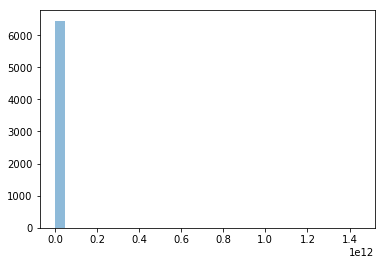

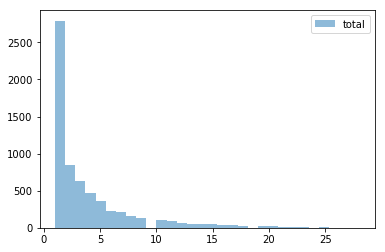

In [111]:
plt.hist(Mental_Health_Score, bins = 30,alpha=.5)
plt.show()
plt.hist(total+1, bins = 30,alpha=.5,label='total')
plt.legend()
plt.show()

In [112]:
total.max()

27.0

In [19]:
list_column_names = 'ALQ120 Alcohol Consumption\nPAQ700 Computer/TV Usage\nBMXBMI BMI (kg/m**2)\nBMXHT Height (cm)\nBMXWAIST Waist Circumference (cm)\nBMXWT Weight (kg)\nBPXDI Diastolic Blood pressure (mmHg)\nBPXPLS 60 sec pulse\nBPXSY Systolic Blood pressure (mmHg)\nDBD100 Salt added to food\nDED125 Time spent outdoors\nDMDCITZN US Citizen\nDMDEDUC2 Education Level\nDMDFMSIZ Family Size\nDMDHHSZA Children <= 5 \nDMDHHSZB Children aged 6-17\nDMDHHSZE Adults > 60 at Home\nDMDMARTL Marital Status\nDPQ010 Little Interest\nDPQ020 Feeling Hopeless\nDPQ030 Trouble Sleeping\nDPQ040 Low Energy\nDPQ050 Irregular Appetite\nDPQ060 Feel Like Failure\nDPQ070 Trouble Concentrating\nDPQ080 Restless\nDPQ090 Self Harm\nDRQSDIET Diet\nDUQ240 Drugs\nINDFMIN2 Total family income\nINDFMPIR Poverty Ratio\nLBXHGB Hemoglobin (g/dL)\nLBXPLTSI Platelet count (1000 cells/uL)\nLBXRBCSI Red blood cell (million cells/uL)\nLBXSCA Total calcium (mg/dL)\nLBXSCH Cholesterol (mg/dL)\nLBXSGL Glucose, refrigerated serum (mg/dL)\nLBXSIR Iron, refrigerated serum (ug/dL)\nLBXTC Total Cholesterol( mg/dL)\nLBXWBCSI White blood cell (1000 cells/uL)\nMCQ220 Cancer\nOCQ180 Hours Worked\nPAD680 Time Spent Sitting\nPAQ710 TV Use\nPAQ715 Computer Use\nRIAGENDR Gender\nRIDAGEYR Age\nRIDRETH3 Race\nSLD010H Average Sleep \nSMQ020 Cigarette Use\nSXD021 Sex\nURDACT Albumin creatinine ratio (mg/g)\nURXCRS Creatinine, urine (umol/L)\nURXUMA Albumin, urine (ug/mL)\nURXUMS Albumin, urine (mg/L)\nWHD0250 Weight Change'
column_names = list_column_names.split('\n')


In [20]:
for c in column_names:
    print(c)

ALQ120 Alcohol Consumption
PAQ700 Computer/TV Usage
BMXBMI BMI (kg/m**2)
BMXHT Height (cm)
BMXWAIST Waist Circumference (cm)
BMXWT Weight (kg)
BPXDI Diastolic Blood pressure (mmHg)
BPXPLS 60 sec pulse
BPXSY Systolic Blood pressure (mmHg)
DBD100 Salt added to food
DED125 Time spent outdoors
DMDCITZN US Citizen
DMDEDUC2 Education Level
DMDFMSIZ Family Size
DMDHHSZA Children <= 5 
DMDHHSZB Children aged 6-17
DMDHHSZE Adults > 60 at Home
DMDMARTL Marital Status
DPQ010 Little Interest
DPQ020 Feeling Hopeless
DPQ030 Trouble Sleeping
DPQ040 Low Energy
DPQ050 Irregular Appetite
DPQ060 Feel Like Failure
DPQ070 Trouble Concentrating
DPQ080 Restless
DPQ090 Self Harm
DRQSDIET Diet
DUQ240 Drugs
INDFMIN2 Total family income
INDFMPIR Poverty Ratio
LBXHGB Hemoglobin (g/dL)
LBXPLTSI Platelet count (1000 cells/uL)
LBXRBCSI Red blood cell (million cells/uL)
LBXSCA Total calcium (mg/dL)
LBXSCH Cholesterol (mg/dL)
LBXSGL Glucose, refrigerated serum (mg/dL)
LBXSIR Iron, refrigerated serum (ug/dL)
LBXTC Tota

In [21]:
l = """ALQ120 Alcohol
PAQ700 Computer/TV
BMXBMI BMI
BMXHT Height
BMXWAIST Waist
BMXWT Weight
BPXDI Blood Pressure 1
BPXPLS Pulse
BPXSY Blood Pressure 2
DBD100 Salt in Food
DED125 Time Outside
DMDCITZN US Citizen
DMDEDUC2 Education
DMDFMSIZ Family Size
DMDHHSZA Children <= 5 
DMDHHSZB Children 6-17
DMDHHSZE Adults > 60 at Home
DMDMARTL Marital Status
DPQ010 Little Interest
DPQ020 Feeling Hopeless
DPQ030 Trouble Sleeping
DPQ040 Low Energy
DPQ050 Irregular Appetite
DPQ060 Feel Like Failure
DPQ070 Trouble Concentrating
DPQ080 Slow or Fidgity 
DPQ090 Self Harm
DRQSDIET Diet
DUQ240 Drugs
INDFMIN2 Income
INDFMPIR Poverty Ratio
LBXHGB Hemoglobin
LBXPLTSI Platelets
LBXRBCSI Red blood cell
LBXSCA Calcium
LBXSGL Glucose
LBXSIR Iron
LBXTC Cholesterol
LBXWBCSI White blood cell
MCQ220 Cancer
OCQ180 Hours Worked
PAD680 Time Sitting
PAQ710 TV Use
PAQ715 Computer Use
RIAGENDR Gender
RIDAGEYR Age
RIDRETH3 Race
SLD010H Sleep 
SMQ020 Smoking
SXD021 Sex
URDACT ACR
URXCRS Creatinine
URXUMA Albumin
URXUMS Albumin
WHD0250 Weight Change"""

In [22]:
l

'ALQ120 Alcohol\nPAQ700 Computer/TV\nBMXBMI BMI\nBMXHT Height\nBMXWAIST Waist\nBMXWT Weight\nBPXDI Blood Pressure 1\nBPXPLS Pulse\nBPXSY Blood Pressure 2\nDBD100 Salt in Food\nDED125 Time Outside\nDMDCITZN US Citizen\nDMDEDUC2 Education\nDMDFMSIZ Family Size\nDMDHHSZA Children <= 5 \nDMDHHSZB Children 6-17\nDMDHHSZE Adults > 60 at Home\nDMDMARTL Marital Status\nDPQ010 Little Interest\nDPQ020 Feeling Hopeless\nDPQ030 Trouble Sleeping\nDPQ040 Low Energy\nDPQ050 Irregular Appetite\nDPQ060 Feel Like Failure\nDPQ070 Trouble Concentrating\nDPQ080 Slow or Fidgity \nDPQ090 Self Harm\nDRQSDIET Diet\nDUQ240 Drugs\nINDFMIN2 Income\nINDFMPIR Poverty Ratio\nLBXHGB Hemoglobin\nLBXPLTSI Platelets\nLBXRBCSI Red blood cell\nLBXSCA Calcium\nLBXSGL Glucose\nLBXSIR Iron\nLBXTC Cholesterol\nLBXWBCSI White blood cell\nMCQ220 Cancer\nOCQ180 Hours Worked\nPAD680 Time Sitting\nPAQ710 TV Use\nPAQ715 Computer Use\nRIAGENDR Gender\nRIDAGEYR Age\nRIDRETH3 Race\nSLD010H Sleep \nSMQ020 Smoking\nSXD021 Sex\nURDACT AC

In [76]:
boolean = ['US Citizen','Marital Status','Diet','Drugs','Smoking','Race','Gender','Sex','Cancer']

for j in boolean:
    print(data.groupby([j])['Depression'].mean(),'\n')

US Citizen
1.0    2.909703
2.0    2.371571
Name: Depression, dtype: float64 

Marital Status
1.0    2.616649
2.0    3.917910
3.0    4.268371
4.0    4.544379
5.0    3.089595
6.0    3.187500
Name: Depression, dtype: float64 

Diet
1.0    3.675497
2.0    2.731568
Name: Depression, dtype: float64 

Drugs
1.0    4.282158
2.0    3.122331
Name: Depression, dtype: float64 

Smoking
1.0    3.664216
2.0    2.656973
Name: Depression, dtype: float64 

Race
1.0    2.718884
2.0    3.128696
3.0    3.041586
4.0    2.830131
6.0    1.804775
Name: Depression, dtype: float64 

Gender
1    2.300099
2    3.342770
Name: Depression, dtype: float64 

Sex
1.0    3.339027
2.0    2.760331
Name: Depression, dtype: float64 

Cancer
1.0    3.716763
2.0    3.025919
Name: Depression, dtype: float64 



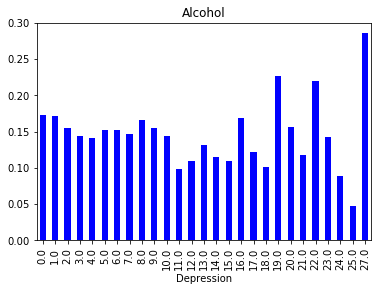

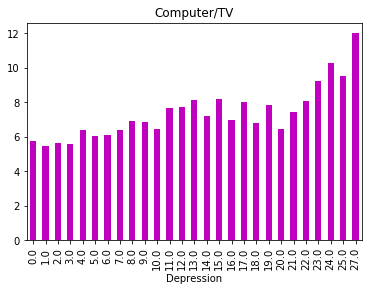

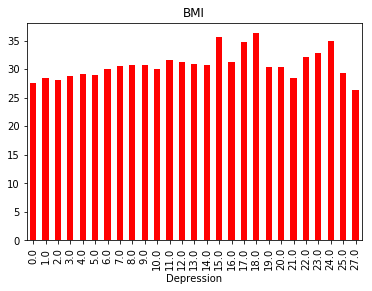

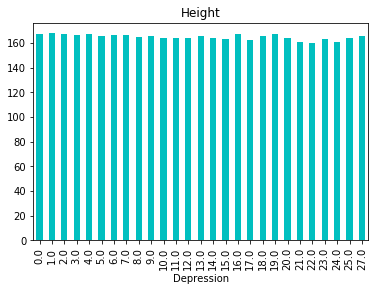

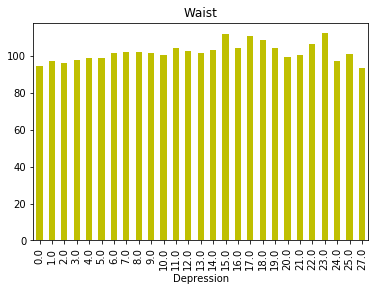

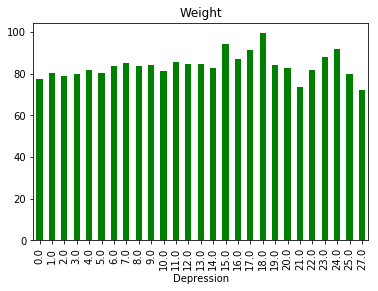

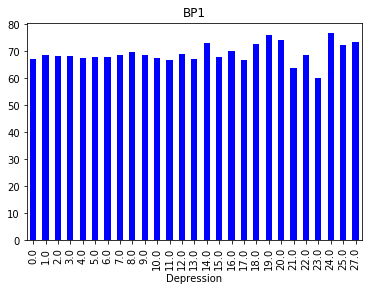

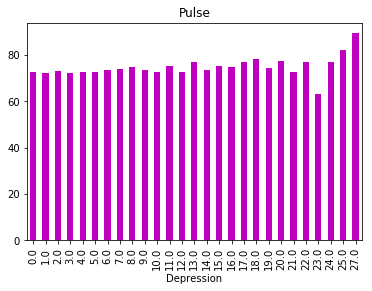

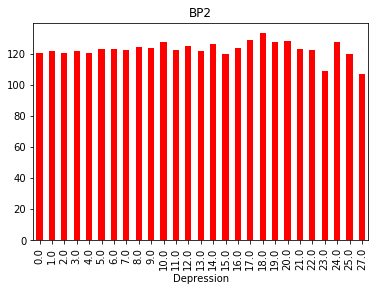

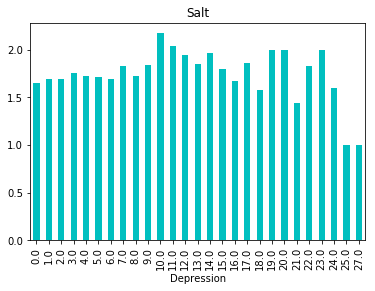

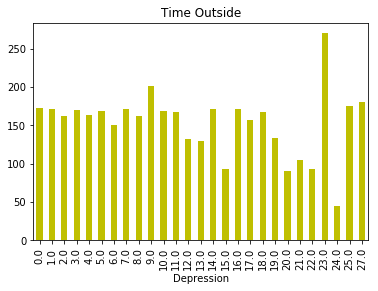

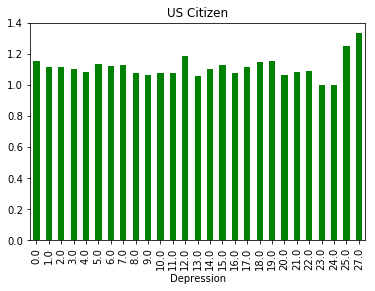

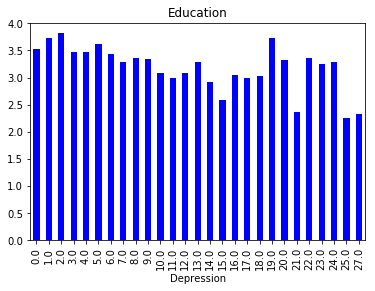

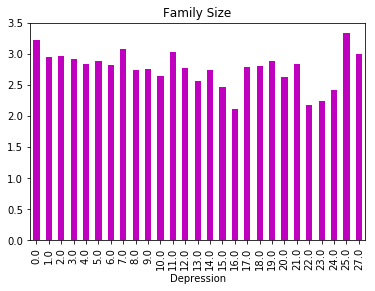

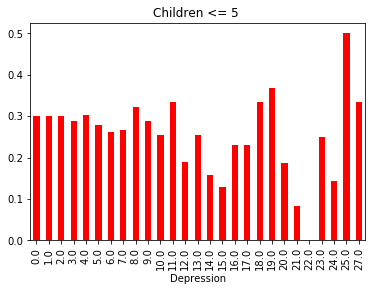

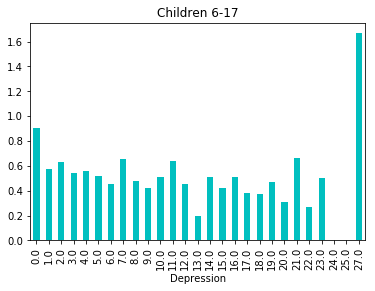

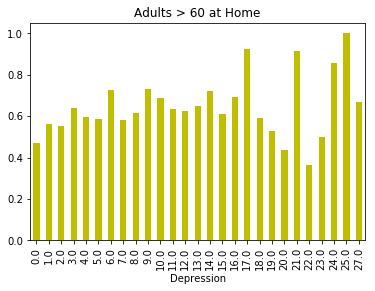

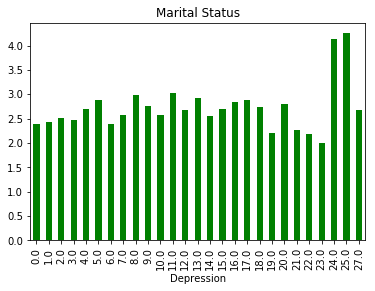

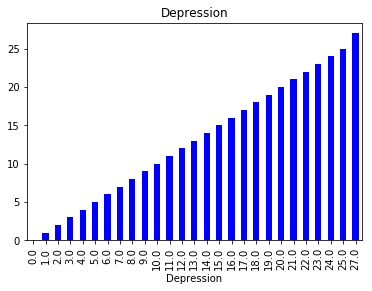

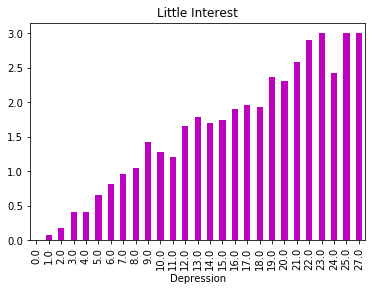

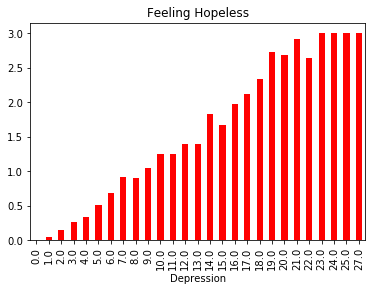

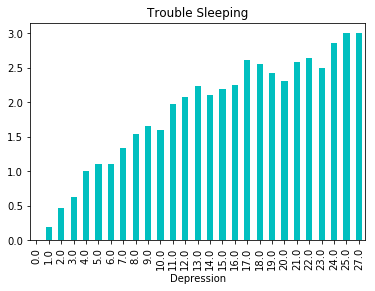

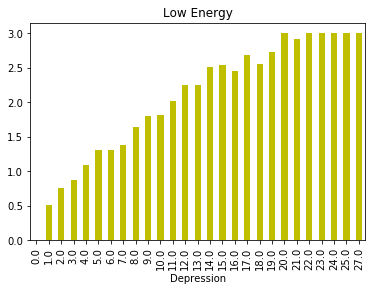

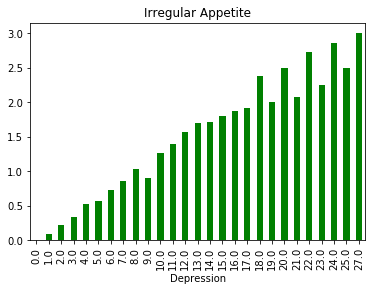

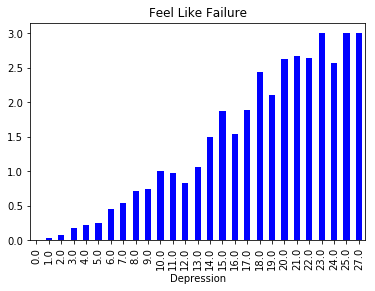

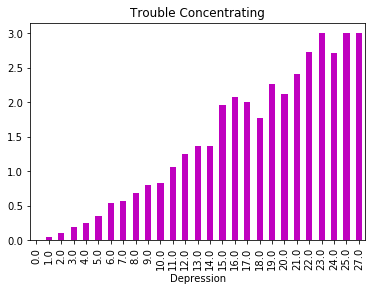

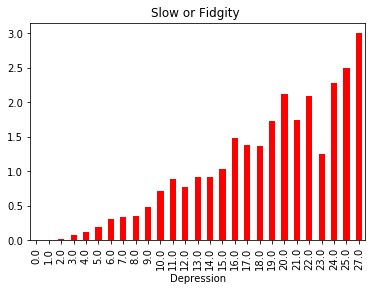

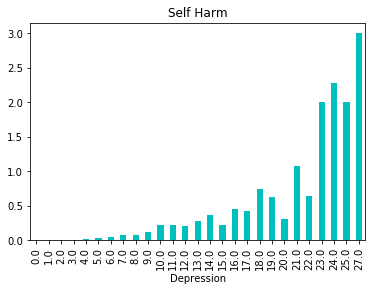

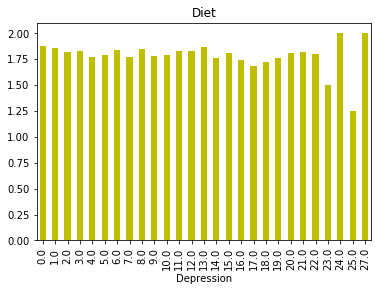

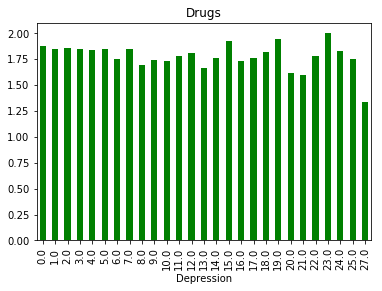

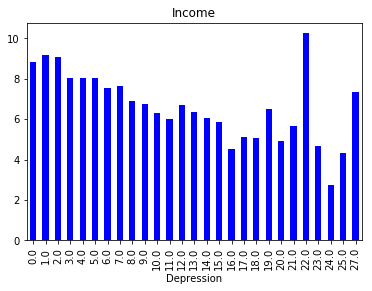

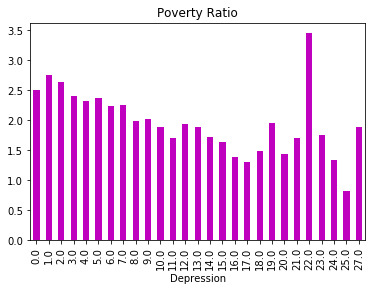

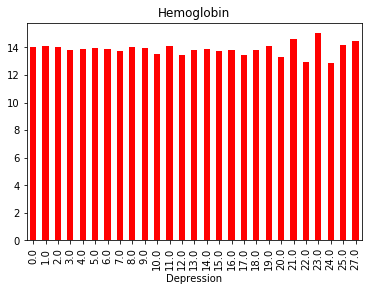

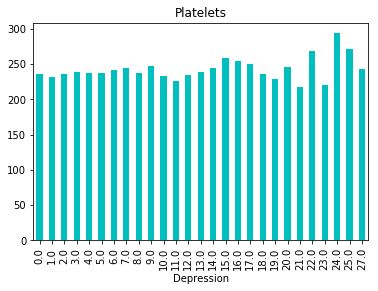

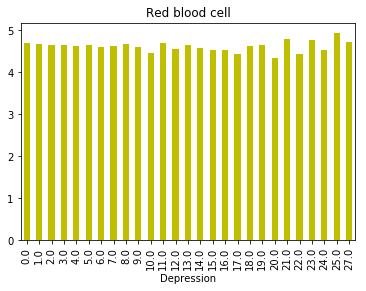

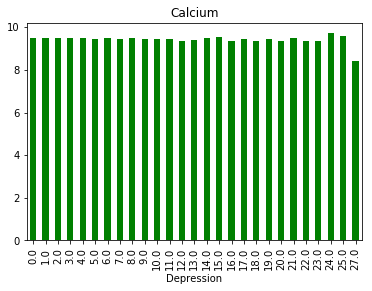

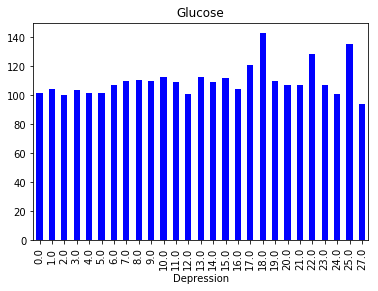

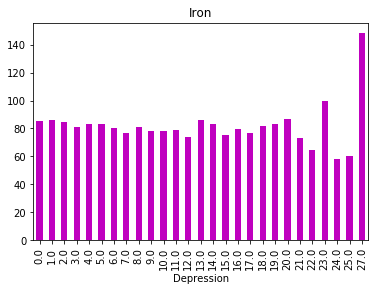

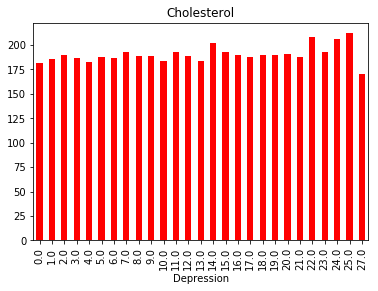

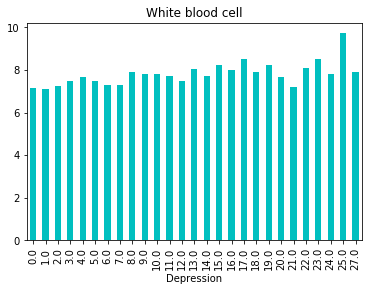

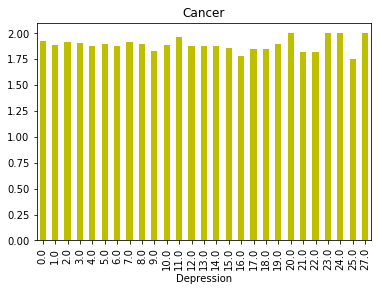

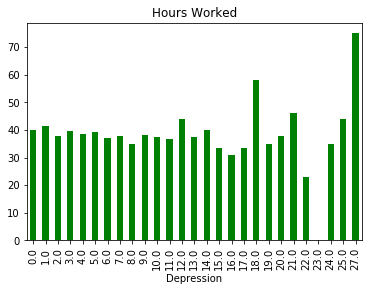

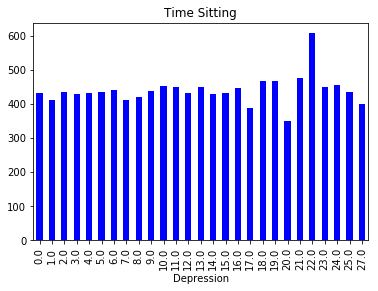

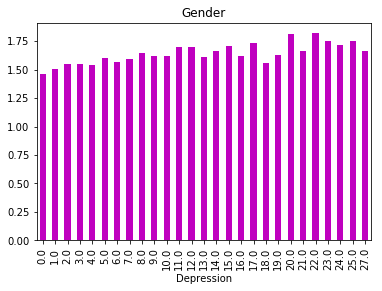

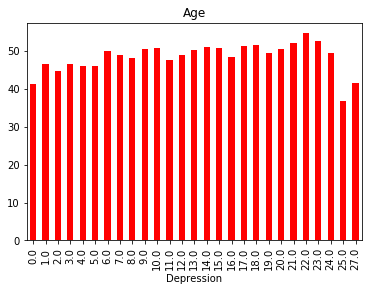

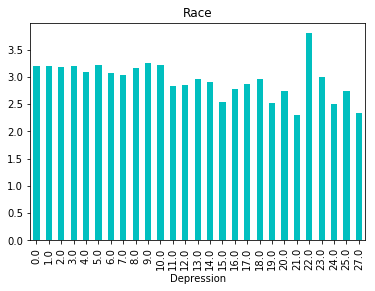

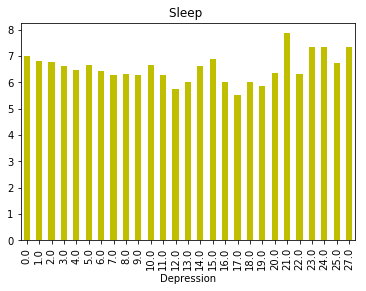

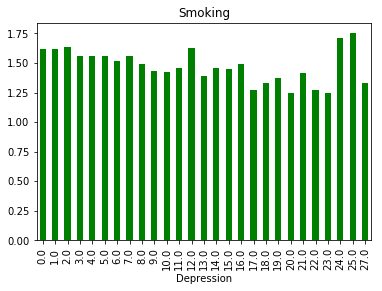

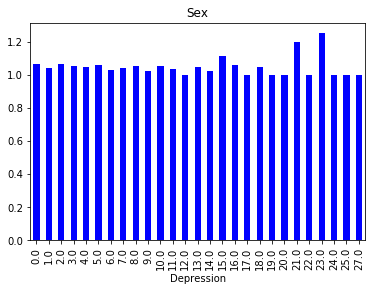

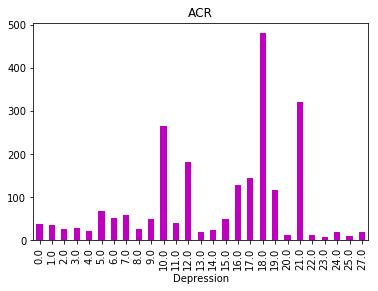

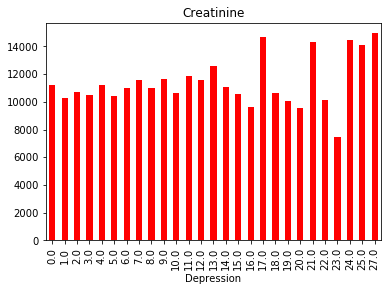

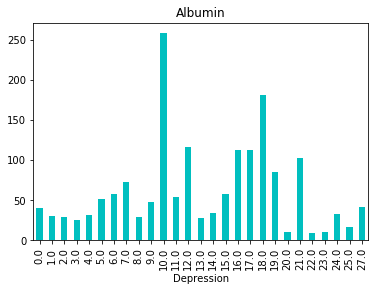

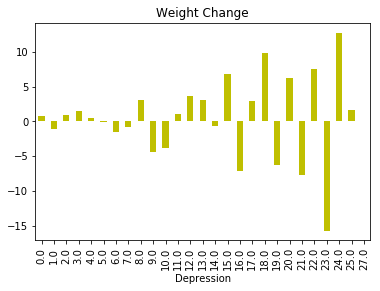

In [72]:
colors = ['b','m','r','c','y','g','b','m','r','c','y','g','b','m','r','c','y','g','b','m','r','c','y','g','b','m','r','c','y','g','b','m','r','c','y','g','b','m','r','c','y','g','b','m','r','c','y','g','b','m','r','c','y','g','b','m','r','c','y','g','b','m','r','c','y','g','b','m','r','c','y','g','b','m','r','c','y','g','b','m','r','c','y','g','b','m','r','c','y','g','b','m','r','c','y','g']

i = 0
for j in variable_descriptions.keys():
    if j in data.columns:
        sep = data.groupby('Depression')
        sep[j].mean().plot(kind='bar',color=colors[i])
        i+=1
        plt.title(j)
        plt.show()

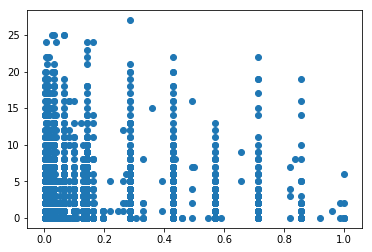

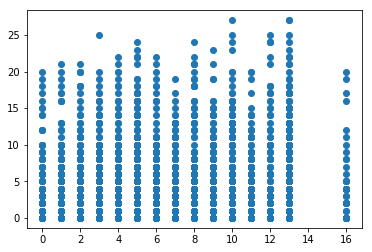

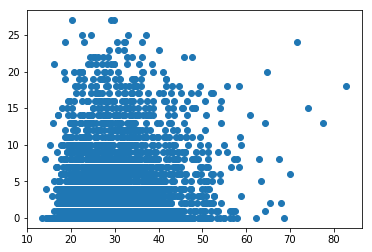

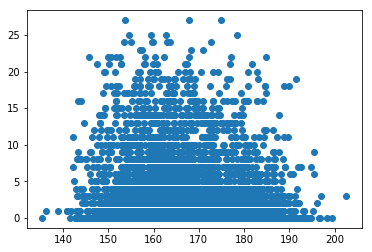

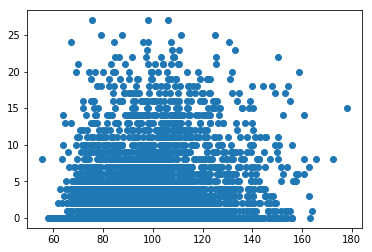

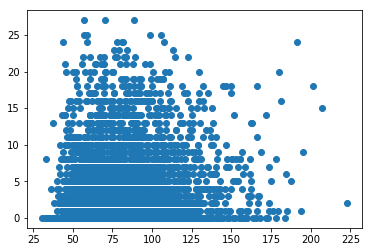

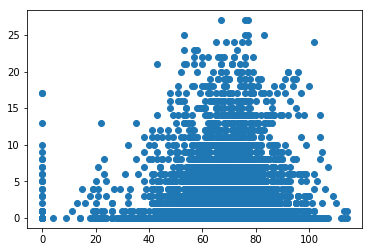

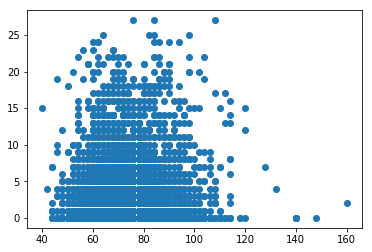

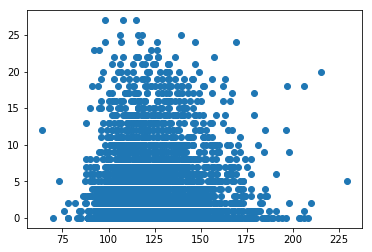

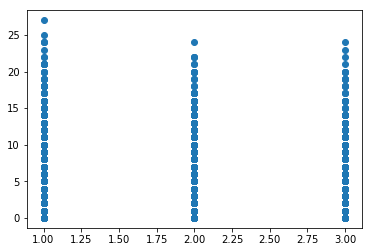

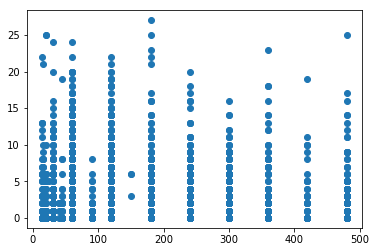

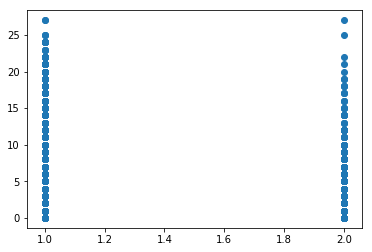

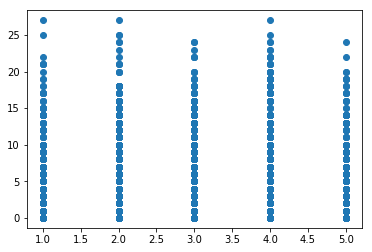

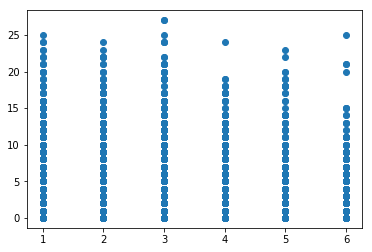

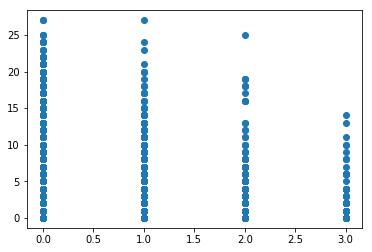

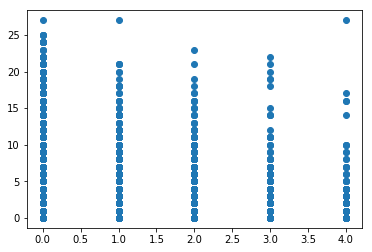

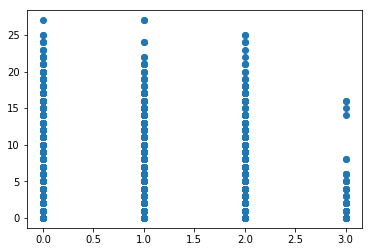

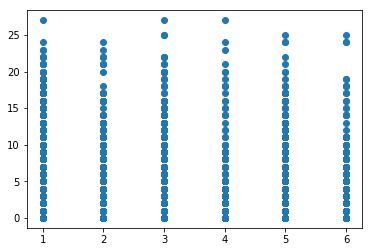

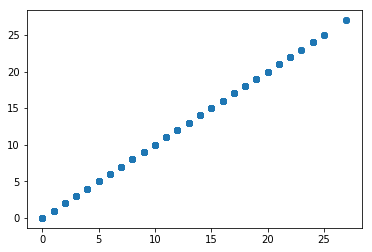

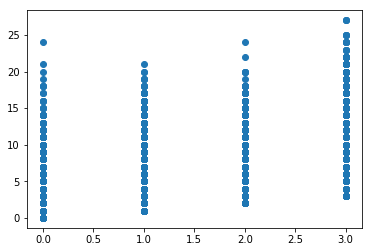

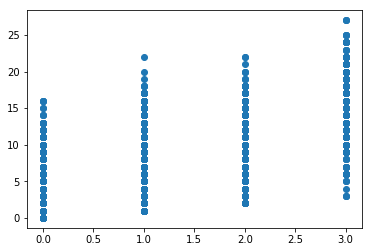

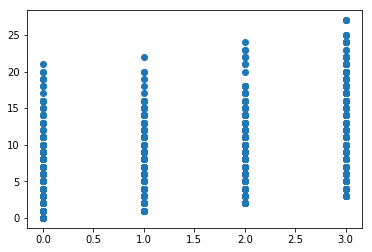

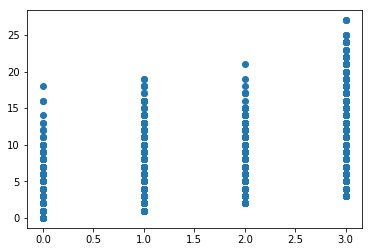

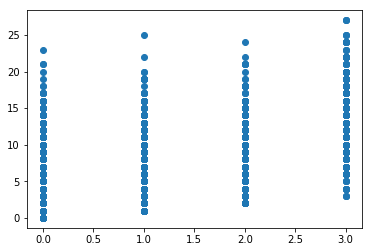

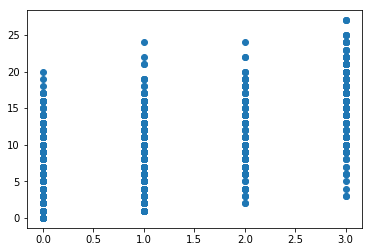

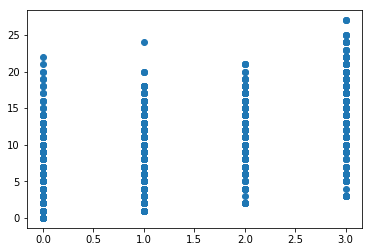

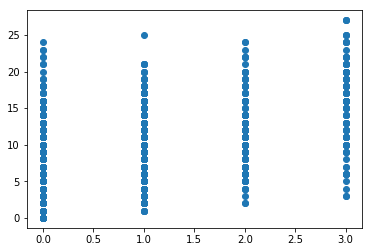

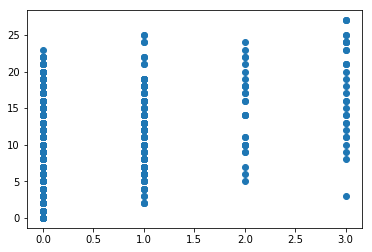

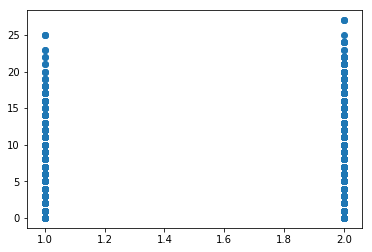

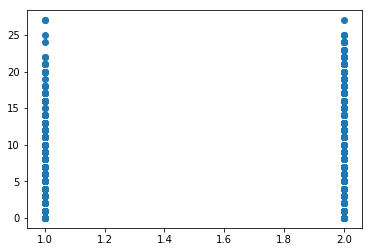

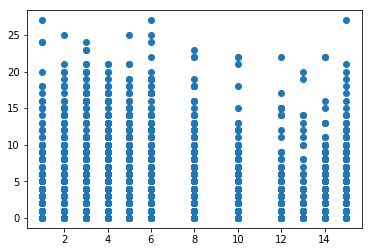

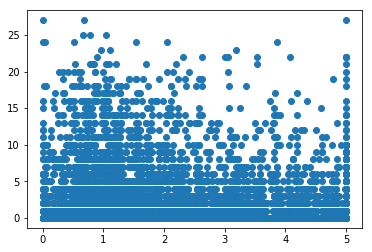

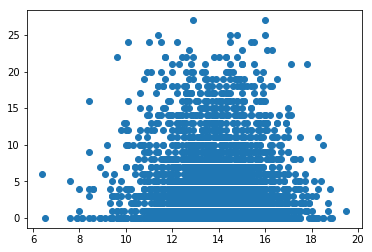

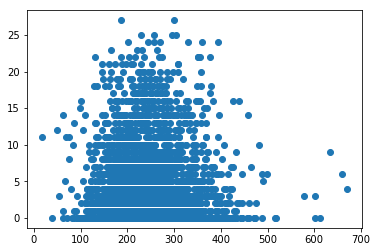

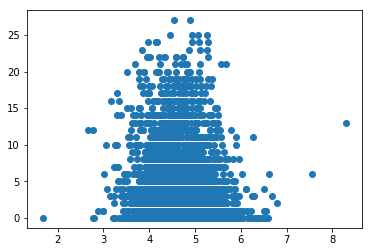

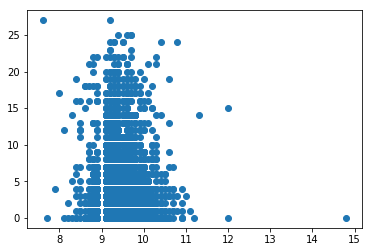

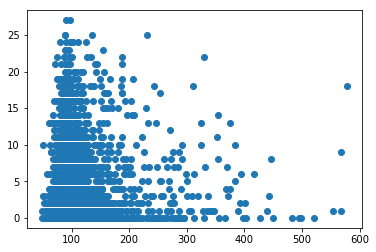

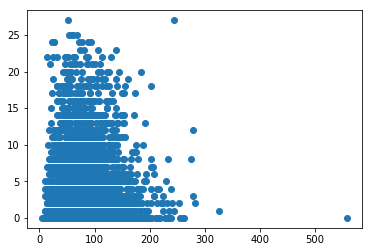

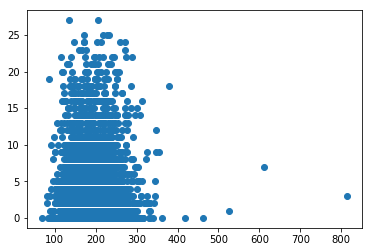

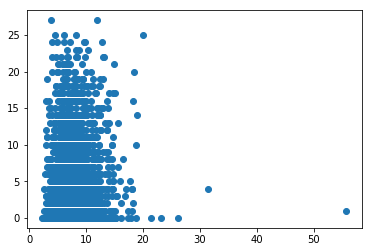

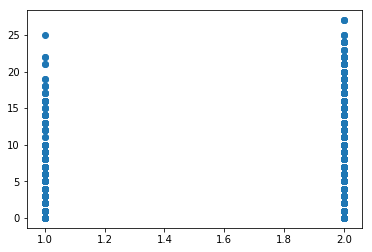

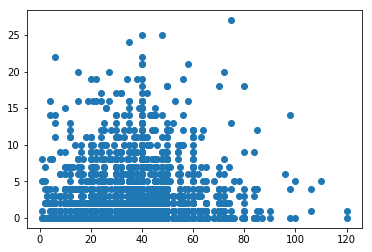

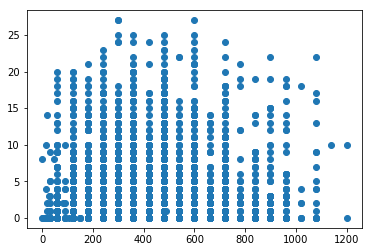

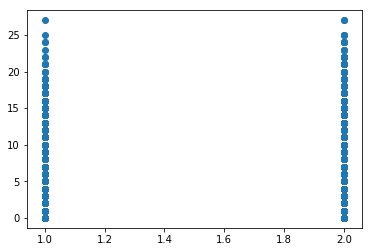

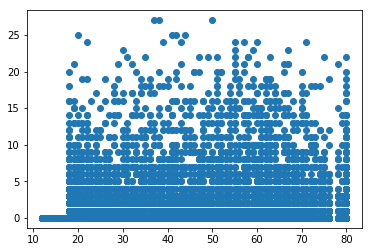

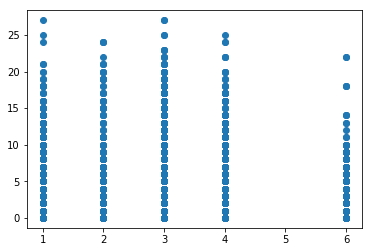

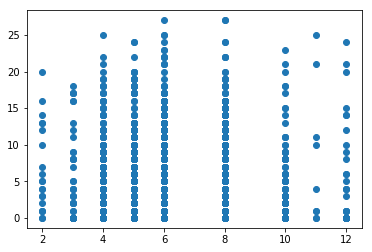

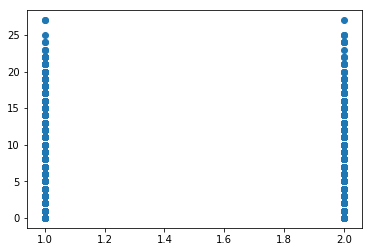

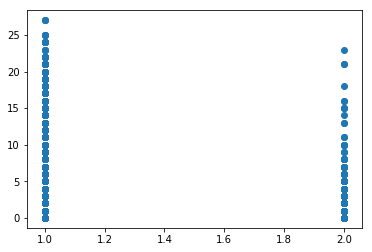

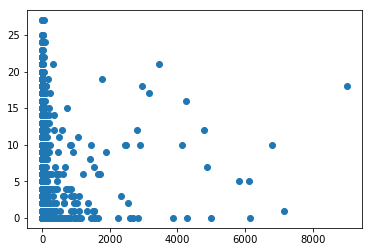

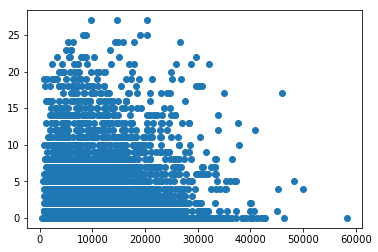

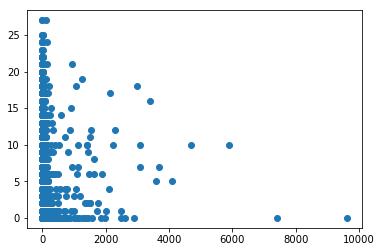

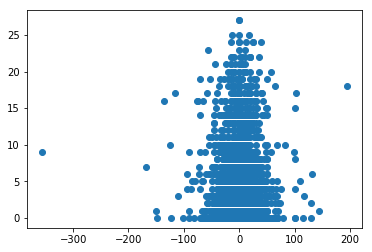

In [73]:
for var in variable_descriptions:
    if var in data.columns:
        plt.scatter(data[var],data['Depression'])
        plt.show()

In [63]:
data['ACR'].dropna()

0        11.03
1       306.00
2        10.53
4       173.47
5       166.22
7         7.85
8         7.22
9        16.28
10       80.65
12       14.58
15        7.51
17        3.01
18        8.90
19        5.27
20        6.32
21        2.79
22        4.95
26        2.70
28        3.90
30        5.70
33        6.30
35        7.19
36       18.75
37       16.40
39        3.61
40       15.00
41        4.76
42        7.63
44       14.43
45        5.47
         ...  
9770      4.88
9771      6.06
9773     44.03
9774      7.27
9775      5.87
9777      3.18
9778      6.21
9780      4.13
9781      5.74
9782      6.46
9783     13.33
9784      9.21
9786      7.03
9788     13.83
9789     10.55
9790      7.57
9792     13.87
9793      3.41
9794     10.25
9795      4.48
9796      6.09
9797      3.25
9798     29.60
9799     10.00
9801      6.77
9802      6.48
9804     10.83
9805      5.98
9808      4.04
9810      5.13
Name: ACR, Length: 6383, dtype: float64